In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from datetime import date
from datetime import timedelta
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 16, 10

In [7]:
base_path = 'csse_covid_19_data/csse_covid_19_daily_reports/'

#start = date.fromisoformat('2020-02-29')
start = date.fromisoformat('2020-03-22')  # prior to 3/22 the format is different and province/state has a mix of counties, and states, etc.
end = date.today()

df_all = pd.DataFrame(columns=['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Last_Update',
                              'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'Combined_Key'])

def rename_column_if_exists(df, old_col_name, new_col_name):
    if old_col_name in df.columns:
        df.rename(columns = {old_col_name: new_col_name}, inplace=True)
        
def str_join(df, sep, *cols):
    from functools import reduce
    return reduce(lambda x, y: x.astype(str).str.cat(y.astype(str), sep=sep), 
                    [df[col] for col in cols])

def create_combined_key_if_missing(df):
    if not 'Combined_Key' in df.columns:
        df.insert(len(df.columns), 'Combined_Key', np.NaN)
    df_missing = df['Combined_Key'].isna()
    df.loc[df_missing,'Combined_Key'] = df.loc[df_missing,:].Province_State.astype(str).str.cat(df.loc[df_missing,:].Country_Region.astype(str), sep=', ', na_rep='')
    
d = end - start
for dayindex in range(0,d.days+1):
    day = start + timedelta(days=dayindex)
    filename = '{:%m-%d-%Y}'.format(day)
    #print(base_path + filename + '.csv')
    try:
        df_input = pd.read_csv(base_path + filename + '.csv')
    except FileNotFoundError as e:
        print('FileNotFoundError - {}'.format(base_path + filename + '.csv'))
        continue
    rename_column_if_exists(df_input, 'Province/State', 'Province_State')
    rename_column_if_exists(df_input, 'Country/Region', 'Country_Region')
    rename_column_if_exists(df_input, 'Last Update', 'Last_Update')
    rename_column_if_exists(df_input, 'Latitude', 'Lat')
    rename_column_if_exists(df_input, 'Longitude', 'Long_')
    create_combined_key_if_missing(df_input)
    df_all = df_all.append(df_input)
    
df_all['Last_Update'] = pd.to_datetime(df_all.Last_Update) 
df_all['Last_Update'] = pd.to_datetime(df_all['Last_Update'].dt.date)  # the ".dt.date" collapses more granular datetime to just the day (so time-of-day differences aren't on different rows)
    
df_all.loc[df_all['Country_Region']=='Guatemala',:]


#df_raw = pd.read_csv('csse_covid_19_data/csse_covid_19_daily_reports/03-30-2020.csv')
#df_raw.head(30)

FileNotFoundError - csse_covid_19_data/csse_covid_19_daily_reports/04-02-2020.csv


,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
3345,NaN,NaN,NaN,Guatemala,2020-03-22,15.7835,-90.2308,19,1,0,18,Guatemala
3314,NaN,NaN,NaN,Guatemala,2020-03-23,15.7835,-90.2308,20,1,0,19,Guatemala
3314,NaN,NaN,NaN,Guatemala,2020-03-24,15.7835,-90.2308,21,1,0,20,Guatemala
3314,NaN,NaN,NaN,Guatemala,2020-03-25,15.7835,-90.2308,24,1,4,19,Guatemala
3313,NaN,NaN,NaN,Guatemala,2020-03-26,15.7835,-90.2308,25,1,4,20,Guatemala
3321,NaN,NaN,NaN,Guatemala,2020-03-27,15.7835,-90.2308,28,1,4,23,Guatemala
3321,NaN,NaN,NaN,Guatemala,2020-03-28,15.7835,-90.2308,34,1,10,23,Guatemala
3325,NaN,NaN,NaN,Guatemala,2020-03-29,15.7835,-90.2308,34,1,10,23,Guatemala
3330,NaN,NaN,NaN,Guatemala,2020-03-30,15.7835,-90.2308,36,1,10,25,Guatemala
2324,NaN,NaN,NaN,Guatemala,2020-03-31,15.7835,-90.2308,38,1,12,25,Guatemala


In [8]:
# Clean it up -- drop unneeded columns and set date as the index
df_clean = df_all.drop(labels=['FIPS', 'Lat', 'Long_'], axis=1)
df_clean = df_clean.melt(id_vars=['Admin2', 'Province_State', 'Country_Region', 'Combined_Key', 'Last_Update'],
            var_name='Metric',
            value_name='Value')
df_clean = df_clean.set_index('Last_Update')
df_clean.loc[df_clean['Country_Region']=='Guatemala'].tail()

,Admin2,Province_State,Country_Region,Combined_Key,Metric,Value
Last_Update,,,,,,
2020-03-28,NaN,NaN,Guatemala,Guatemala,Active,23
2020-03-29,NaN,NaN,Guatemala,Guatemala,Active,23
2020-03-30,NaN,NaN,Guatemala,Guatemala,Active,25
2020-03-31,NaN,NaN,Guatemala,Guatemala,Active,25
2020-04-01,NaN,NaN,Guatemala,Guatemala,Active,26


In [9]:
# Examples of dealing with the data in this format

# Just the death information for Santa Clara County
df_clean.loc[(df_clean.Admin2 == 'Santa Clara') & (df_clean.Metric == 'Deaths')]

# Just Confirmed Cases for Canadian Provinces
df_clean.loc[(df_clean.Metric == 'Confirmed') & (df_clean.Country_Region == 'Canada'), ['Province_State', 'Value']]

# Get the above (confirmed for Canadian Provinces) ready to graph (wide format with column labels being location)
(df_clean.loc[(df_clean.Metric == 'Confirmed') & (df_clean.Country_Region == 'Canada'), ['Province_State', 'Value']]
     .reset_index()     # make the index a column for now
     .pivot_table(index='Last_Update', columns='Province_State', values='Value', aggfunc=np.sum) #pivot() doesn't work because of duplicate indices
)

Province_State,Alberta,British Columbia,Diamond Princess,Grand Princess,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Ontario,Prince Edward Island,Quebec,Recovered,Saskatchewan,Yukon
Last_Update,,,,,,,,,,,,,,,
2020-03-22,259.0,424.0,0.0,13.0,20.0,17.0,9.0,1.0,28.0,425.0,3.0,219.0,NaN,52.0,NaN
2020-03-23,301.0,472.0,0.0,13.0,20.0,17.0,24.0,NaN,41.0,503.0,3.0,628.0,NaN,66.0,NaN
2020-03-24,359.0,617.0,0.0,13.0,21.0,18.0,35.0,NaN,51.0,588.0,3.0,1013.0,0.0,72.0,NaN
2020-03-25,358.0,617.0,0.0,13.0,35.0,18.0,35.0,NaN,68.0,688.0,5.0,1342.0,0.0,72.0,NaN
2020-03-26,486.0,725.0,0.0,13.0,36.0,33.0,82.0,1.0,73.0,858.0,5.0,1632.0,0.0,95.0,3.0
2020-03-27,542.0,725.0,0.0,13.0,39.0,45.0,102.0,1.0,90.0,994.0,9.0,2024.0,0.0,95.0,3.0
2020-03-28,542.0,884.0,0.0,13.0,64.0,51.0,120.0,1.0,110.0,1144.0,11.0,2498.0,0.0,134.0,4.0
2020-03-29,621.0,884.0,0.0,13.0,72.0,66.0,135.0,1.0,122.0,1355.0,11.0,2840.0,0.0,156.0,4.0
2020-03-30,661.0,970.0,0.0,13.0,96.0,68.0,148.0,1.0,127.0,1706.0,18.0,3430.0,0.0,156.0,4.0


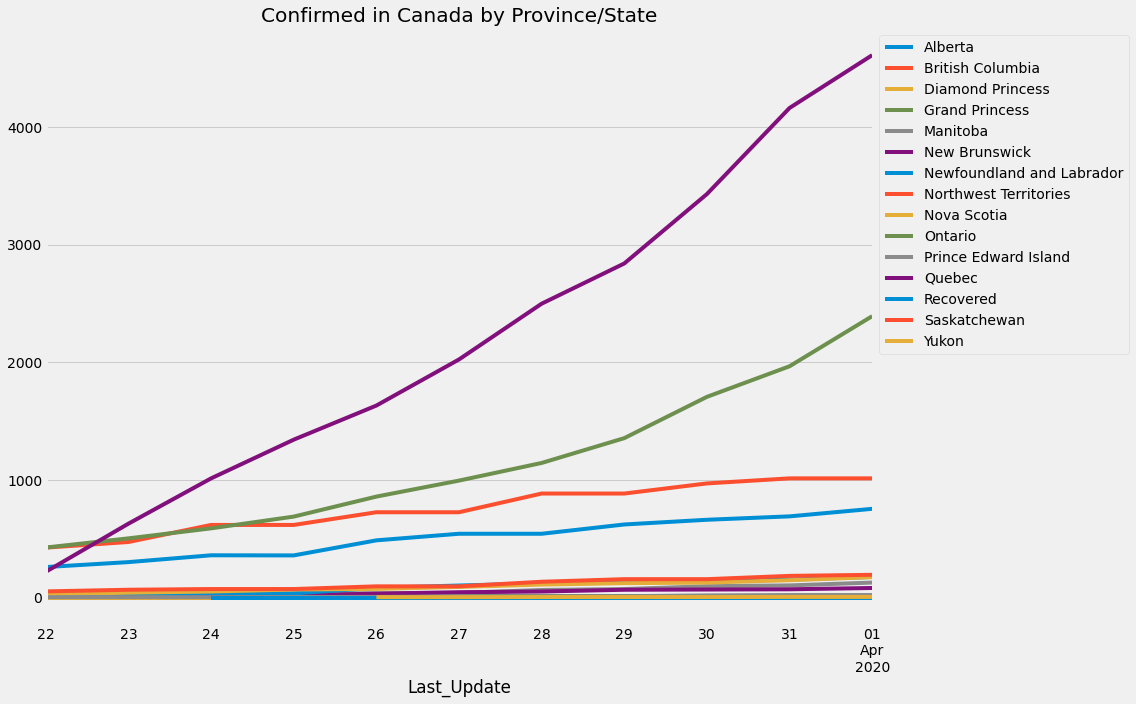

In [10]:
metric = 'Confirmed'
location = 'Canada'
(df_clean.loc[(df_clean.Metric == metric) & (df_clean.Country_Region == location), ['Province_State', 'Value']]
     .reset_index()     # make the index a column for now
     .pivot_table(index='Last_Update', columns='Province_State', values='Value', aggfunc=np.sum)
     .loc['2020-03':,:]
).plot()
plt.legend(bbox_to_anchor=(1, 1))
plt.title('{} in {} by Province/State'.format(metric, location))
plt.tight_layout()
sns.despine()
plt.show()

## Alternative one -- just use Combined_Key

In [11]:
piv1 = df_clean.pivot_table(index=df_clean.index, columns=['Metric','Combined_Key'], values='Value', aggfunc=np.sum)
piv1.tail() # Note the MultiIndex for the columns (Metric, Combined_Key)

Metric         Active                                                         \
Combined_Key ,,Belize ,,MS Zaandam ,,Mauritania ,Northern Mariana Islands,US   
Last_Update                                                                    
2020-03-28        2.0          2.0          5.0                          NaN   
2020-03-29        2.0          2.0          3.0                          NaN   
2020-03-30        3.0          2.0          2.0                          NaN   
2020-03-31        3.0          2.0          3.0                          0.0   
2020-04-01        3.0          7.0          3.0                          0.0   

Metric                                                                       \
Combined_Key ,Northwest Territories,Canada ,Virgin Islands,US ,Yukon,Canada   
Last_Update                                                                   
2020-03-28                             0.0                NaN           0.0   
2020-03-29                             0.0                NaN           0.0   
2020-03-30                             0.0                NaN           0.0   
2020-03-31                             0.0                0.0           0.0   
2020-04-01                             0.0                0.0           0.0   

Metric                                                            \
Combined_Key Abbeville, South Carolina, US Acadia, Louisiana, US   
Last_Update                                                        
2020-03-28                             0.0                   0.0   
2020-03-29                             0.0                   0.0   
2020-03-30                             0.0                   0.0   
2020-03-31                             0.0                   0.0   
2020-04-01                             0.0                   0.0   

Metric                               ...                 Recovered  \
Combined_Key Accomack, Virginia, US  ... Yukon-Koyukuk, Alaska, US   
Last_Update                          ...                             
2020-03-28                      0.0  ...                       0.0   
2020-03-29                      0.0  ...                       0.0   
2020-03-30                      0.0  ...                       0.0   
2020-03-31                      0.0  ...                       NaN   
2020-04-01                      0.0  ...                       NaN   

Metric                                                                  \
Combined_Key Yuma, Arizona, US Yuma, Colorado, US Yunnan, China Zambia   
Last_Update                                                              
2020-03-28                 0.0                0.0           NaN    0.0   
2020-03-29                 0.0                0.0           NaN    0.0   
2020-03-30                 0.0                0.0           NaN    0.0   
2020-03-31                 0.0                0.0         344.0    0.0   
2020-04-01                 0.0                0.0           NaN    0.0   

Metric                                                            \
Combined_Key Zapata, Texas, US Zavala, Texas, US Zhejiang, China   
Last_Update                                                        
2020-03-28                 0.0               0.0          1225.0   
2020-03-29                 0.0               0.0          1225.0   
2020-03-30                 0.0               0.0          1225.0   
2020-03-31                 NaN               NaN          2452.0   
2020-04-01                 NaN               NaN             NaN   

Metric                                           
Combined_Key Ziebach, South Dakota, US Zimbabwe  
Last_Update                                      
2020-03-28                         0.0      0.0  
2020-03-29                         0.0      0.0  
2020-03-30                         0.0      0.0  
2020-03-31                         NaN      0.0  
2020-04-01                         NaN      0.0  

[5 rows x 14032 columns]

In [12]:
# look at just the deaths (Metric == 'Deaths') aka the top level of the MultiIndex is 'Deaths'
idx = pd.IndexSlice
piv1.loc[:,idx['Deaths']]

Combined_Key,",,Belize",",,MS Zaandam",",,Mauritania",",Northern Mariana Islands,US",",Northwest Territories,Canada",",Virgin Islands,US",",Yukon,Canada","Abbeville, South Carolina, US","Acadia, Louisiana, US","Accomack, Virginia, US",...,"Yukon-Koyukuk, Alaska, US","Yuma, Arizona, US","Yuma, Colorado, US","Yunnan, China",Zambia,"Zapata, Texas, US","Zavala, Texas, US","Zhejiang, China","Ziebach, South Dakota, US",Zimbabwe
Last_Update,,,,,,,,,,,,,,,,,,,,,
2020-02-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Look at just deaths in California
# (must use columns.map() because you can't use .str.endswith on a MultiIndex)
piv1.loc[:,idx['Deaths', piv1.columns.map(lambda x: x[1].endswith('California, US'))]]

Metric                        Deaths                         \
Combined_Key Alameda, California, US Alpine, California, US   
Last_Update                                                   
2020-02-23                       NaN                    NaN   
2020-03-08                       NaN                    NaN   
2020-03-12                       NaN                    NaN   
2020-03-13                       NaN                    NaN   
2020-03-14                       NaN                    NaN   
2020-03-16                       NaN                    NaN   
2020-03-18                       NaN                    NaN   
2020-03-19                       NaN                    NaN   
2020-03-20                       NaN                    NaN   
2020-03-21                       NaN                    NaN   
2020-03-22                       0.0                    0.0   
2020-03-23                       1.0                    0.0   
2020-03-24                       2.0                    0.0   
2020-03-25                       2.0                    0.0   
2020-03-26                       4.0                    0.0   
2020-03-27                       4.0                    0.0   
2020-03-28                       4.0                    0.0   
2020-03-29                       6.0                    0.0   
2020-03-30                       7.0                    0.0   
2020-03-31                       7.0                    NaN   
2020-04-01                       7.0                    0.0   

Metric                                                     \
Combined_Key Amador, California, US Butte, California, US   
Last_Update                                                 
2020-02-23                      NaN                   NaN   
2020-03-08                      NaN                   NaN   
2020-03-12                      NaN                   NaN   
2020-03-13                      NaN                   NaN   
2020-03-14                      NaN                   NaN   
2020-03-16                      NaN                   NaN   
2020-03-18                      NaN                   NaN   
2020-03-19                      NaN                   NaN   
2020-03-20                      NaN                   NaN   
2020-03-21                      NaN                   NaN   
2020-03-22                      0.0                   0.0   
2020-03-23                      0.0                   0.0   
2020-03-24                      0.0                   0.0   
2020-03-25                      0.0                   0.0   
2020-03-26                      0.0                   0.0   
2020-03-27                      0.0                   0.0   
2020-03-28                      0.0                   0.0   
2020-03-29                      0.0                   0.0   
2020-03-30                      0.0                   0.0   
2020-03-31                      0.0                   0.0   
2020-04-01                      0.0                   0.0   

Metric                                                         \
Combined_Key Calaveras, California, US Colusa, California, US   
Last_Update                                                     
2020-02-23                         NaN                    NaN   
2020-03-08                         NaN                    NaN   
2020-03-12                         NaN                    NaN   
2020-03-13                         NaN                    NaN   
2020-03-14                         NaN                    NaN   
2020-03-16                         NaN                    NaN   
2020-03-18                         NaN                    NaN   
2020-03-19                         NaN                    NaN   
2020-03-20                         NaN                    NaN   
2020-03-21                         NaN                    NaN   
2020-03-22                         0.0                    0.0   
2020-03-23                         0.0                    0.0   
2020-03-24                         0.0         

## Alternative Two (PREFERRED) - Use Country, State, Admin2 fields

First, an example of dealing with a column you want to use in a pivot_table that has nulls.

In [14]:
test = pd.DataFrame(
                    [
                        ['US','California',1],
                        ['US','New York',3],
                        ['Italy',np.NaN,10]
                    ],
                    columns = ['country', 'state', 'value'],
                   )
print(test)
print('\nIf you dont fix the null values and use pivot_table specifying a column with null values, youll lose info (as we lose Italy here)')
print(test.pivot_table( index=test.index, 
            columns=['country','state'], 
            values=['value'], 
            aggfunc=np.sum, 
            dropna=True ) )
print('\nNow do a .fillna(value={"column_name":"new_value"}) first and it is OK')
(test
     .fillna(value={'state':'none'})
     .pivot_table( index=test.index, 
            columns=['country','state'], 
            values=['value'], 
            aggfunc=np.sum, 
            dropna=True ) 
)

  country       state  value
0      US  California      1
1      US    New York      3
2   Italy         NaN     10

If you dont fix the null values and use pivot_table specifying a column with null values, youll lose info (as we lose Italy here)
             value         
country         US         
state   California New York
0              1.0      NaN
1              NaN      3.0

Now do a .fillna(value={"column_name":"new_value"}) first and it is OK


value                    
country Italy         US         
state    none California New York
0         NaN        1.0      NaN
1         NaN        NaN      3.0
2        10.0        NaN      NaN

In [18]:
df = (df_clean
          .fillna(value={'Province_State':'none', 'Admin2':'none', 'Country_Region':'none'}) # if you don't do this, countries without state or admin2 will be filtered out.
          .pivot_table(index=df_clean.index, 
                          columns=['Metric','Country_Region','Province_State','Admin2'], 
                          values=['Value'], 
                          aggfunc=np.sum
                      )
     )
df = df.loc['20200322':,:]
df

Value                                                     \
Metric              Active                                                      
Country_Region Afghanistan Albania Algeria Andorra Angola Antigua and Barbuda   
Province_State        none    none    none    none   none                none   
Admin2                none    none    none    none   none                none   
Last_Update                                                                     
2020-03-22            38.0    85.0   119.0   111.0    2.0                 1.0   
2020-03-23            38.0    98.0   148.0   131.0    3.0                 3.0   
2020-03-24            72.0   108.0   221.0   162.0    3.0                 3.0   
2020-03-25            80.0   124.0   216.0   186.0    3.0                 3.0   
2020-03-26            88.0   151.0   313.0   220.0    4.0                 7.0   
2020-03-27           104.0   147.0   354.0   263.0    4.0                 7.0   
2020-03-28           104.0   156.0   394.0   304.0    5.0                 7.0   
2020-03-29           114.0   169.0   449.0   327.0    5.0                 7.0   
2020-03-30           164.0   168.0   512.0   352.0    5.0                 7.0   
2020-03-31           165.0   176.0   626.0   354.0    4.0                 7.0   
2020-04-01           228.0   177.0   728.0   366.0    5.0                 7.0   

                                                               \
Metric                                                          
Country_Region Argentina Armenia                    Australia   
Province_State      none    none Australian Capital Territory   
Admin2              none    none                         none   
Last_Update                                                     
2020-03-22         235.0   192.0                         19.0   
2020-03-23         235.0   233.0                         32.0   
2020-03-24         329.0   235.0                         39.0   
2020-03-25         327.0   249.0                         39.0   
2020-03-26         430.0   271.0                         52.0   
2020-03-27         504.0   300.0                         61.0   
2020-03-28         600.0   376.0                         69.0   
2020-03-29         654.0   391.0                         75.0   
2020-03-30         569.0   449.0                         75.0   
2020-03-31         787.0   499.0                         76.0   
2020-04-01         778.0   536.0                         75.0   

                                     ...                 \
Metric                               ...      Recovered   
Country_Region                       ... United Kingdom   
Province_State External territories  ...     Montserrat   
Admin2                         none  ...           none   
Last_Update                          ...                  
2020-03-22                      0.0  ...            0.0   
2020-03-23                      NaN  ...            0.0   
2020-03-24                      NaN  ...            0.0   
2020-03-25                      NaN  ...            0.0   
2020-03-26                      NaN  ...            0.0   
2020-03-27                      NaN  ...            0.0   
2020-03-28                      NaN  ...            0.0   
2020-03-29                      NaN  ...            0.0   
2020-03-30                      NaN  ...            0.0   
2020-03-31                      NaN  ...            0.0   
2020-04-01                      NaN  ...            0.0   

                                                                             \
Metric                                                                        
Country_Region                                 Uruguay Uzbekistan Venezuela   
Province_State Turks and Caicos Islands   none    none       none      none   
Admin2                             none   none    none       none      none   
Last_Update                                                                   
2020-03-22                          NaN   93.0     0.0     

#### Trick:  Deleting columns with all zeros

In [19]:
test = pd.DataFrame([[1,0,0,0], [0,0,0,0],[0,0,1,0]], columns=['a','b','c','d'])
print(test)

print('\n"test!=0"  gives a true/false where there are non-zeros')
print(test!=0)

print('\nThe "any" function with axis=0 reduces along row to give true for any column with a true in it')
print((test!=0).any(axis=0))

print('\nNow just select the rows with a true in order to drop the rows with all zeros\ntest.loc[:,(test!=0).any(axis=0)]')
print(test.loc[:,(test!=0).any(axis=0)])

print('\nTo drop *rows* of all zero, just change axis=1 and put it in the rows position of loc instead \ntest.loc[(test!=0).any(axis=1),:]')
print(test.loc[(test!=0).any(axis=1),:])

   a  b  c  d
0  1  0  0  0
1  0  0  0  0
2  0  0  1  0

"test!=0"  gives a true/false where there are non-zeros
       a      b      c      d
0   True  False  False  False
1  False  False  False  False
2  False  False   True  False

The "any" function with axis=0 reduces along row to give true for any column with a true in it
a     True
b    False
c     True
d    False
dtype: bool

Now just select the rows with a true in order to drop the rows with all zeros
test.loc[:,(test!=0).any(axis=0)]
   a  c
0  1  0
1  0  0
2  0  1

To drop *rows* of all zero, just change axis=1 and put it in the rows position of loc instead 
test.loc[(test!=0).any(axis=1),:]
   a  b  c  d
0  1  0  0  0
2  0  0  1  0


In [20]:
# eliminate all the columns that are all zero and all the rows that are all zero
# note how using lambda allows us to do this without using temp variables for the 'deaths'/'california' subset
test = (df.loc[:,idx[:,'Deaths',:,'California']]
           .fillna(value=0)                        # replace NaN wit zero -- filters below work better then
           .loc[:,lambda df: (df!=0).any(axis=0)]  # drop columns of all zeros
           .loc[lambda df: (df!=0).any(axis=1),:]   # drop rows of all zeros
       )


# eliminate all the columns that are all zero and all the rows that are all zero
df = (df
           .fillna(value=0)                        # replace NaN wit zero -- filters below work better then
           .loc[:,lambda df: (df!=0).any(axis=0)]  # drop columns of all zeros
           .loc[lambda df: (df!=0).any(axis=1),:]   # drop rows of all zeros
       )
df

Value                                                     \
Metric              Active                                                      
Country_Region Afghanistan Albania Algeria Andorra Angola Antigua and Barbuda   
Province_State        none    none    none    none   none                none   
Admin2                none    none    none    none   none                none   
Last_Update                                                                     
2020-03-22            38.0    85.0   119.0   111.0    2.0                 1.0   
2020-03-23            38.0    98.0   148.0   131.0    3.0                 3.0   
2020-03-24            72.0   108.0   221.0   162.0    3.0                 3.0   
2020-03-25            80.0   124.0   216.0   186.0    3.0                 3.0   
2020-03-26            88.0   151.0   313.0   220.0    4.0                 7.0   
2020-03-27           104.0   147.0   354.0   263.0    4.0                 7.0   
2020-03-28           104.0   156.0   394.0   304.0    5.0                 7.0   
2020-03-29           114.0   169.0   449.0   327.0    5.0                 7.0   
2020-03-30           164.0   168.0   512.0   352.0    5.0                 7.0   
2020-03-31           165.0   176.0   626.0   354.0    4.0                 7.0   
2020-04-01           228.0   177.0   728.0   366.0    5.0                 7.0   

                                                                               \
Metric                                                                          
Country_Region Argentina Armenia                    Australia                   
Province_State      none    none Australian Capital Territory New South Wales   
Admin2              none    none                         none            none   
Last_Update                                                                     
2020-03-22         235.0   192.0                         19.0           659.0   
2020-03-23         235.0   233.0                         32.0           659.0   
2020-03-24         329.0   235.0                         39.0           807.0   
2020-03-25         327.0   249.0                         39.0          1018.0   
2020-03-26         430.0   271.0                         52.0          1208.0   
2020-03-27         504.0   300.0                         61.0          1394.0   
2020-03-28         600.0   376.0                         69.0          1605.0   
2020-03-29         654.0   391.0                         75.0          1779.0   
2020-03-30         569.0   449.0                         75.0          2020.0   
2020-03-31         787.0   499.0                         76.0          2020.0   
2020-04-01         778.0   536.0                         75.0          2169.0   

                ...                                                          \
Metric          ... Recovered                                                 
Country_Region  ...   Ukraine United Arab Emirates United Kingdom             
Province_State  ...      none                 none        Bermuda Gibraltar   
Admin2          ...      none                 none           none      none   
Last_Update     ...                                                           
2020-03-22      ...       1.0                 38.0            0.0       2.0   
2020-03-23      ...       1.0                 41.0            0.0       5.0   
2020-03-24      ...       1.0                 45.0            0.0       5.0   
2020-03-25      ...       1.0                 52.0            0.0       5.0   
2020-03-26      ...       1.0                 52.0            2.0      13.0   
2020-03-27      ...       5.0                 52.0            2.0      14.0   
2020-03-28      ...       5.0                 52.0            2.0      14.0   
2020-03-29      ...       6.0                 58.0            2.0      14.0   
2020-03-30      ...       8.0                 61.0            2.0      34.0   
2020-03-31      ...      10.0                 61.0           10.0      34.0   
2

### Using pd.IndexSlice and slice()

In [21]:
idx = pd.IndexSlice
Any = slice(None)  # could also just use ":", but this is a bit clearer

df.loc[:,idx[Any,Any,Any,Any,'Santa Clara']]

Value            
Metric           Confirmed      Deaths
Country_Region          US          US
Province_State  California  California
Admin2         Santa Clara Santa Clara
Last_Update                           
2020-03-22           263.0         8.0
2020-03-23           302.0        10.0
2020-03-24           375.0        16.0
2020-03-25           459.0        17.0
2020-03-26           542.0        19.0
2020-03-27           574.0        20.0
2020-03-28           591.0        25.0
2020-03-29           646.0        25.0
2020-03-30           848.0        28.0
2020-03-31           890.0        30.0
2020-04-01           956.0        32.0

### Label_lines routine - now with tuple_selector option

In [22]:
def label_lines(df, ax, tuple_selector=None):
    '''Labels lines in a chart assuming that some lines will be different lengths than others
       If tuple_selector is set to an integer, use it as an index to the label'''
    for label, series in df.items():
        prev_x = series.index[0]
        prev_data = series.iloc[0]
        for index, data in series.items():
            if pd.isnull(data):
                break
            prev_x = index
            prev_data = data
        if tuple_selector:
            label = label[tuple_selector]
        ax.annotate(label, (prev_x, prev_data),
                            xytext=(10,0), 
                            textcoords='offset pixels',
                            family='sans-serif', fontsize=14, color='darkslategrey')

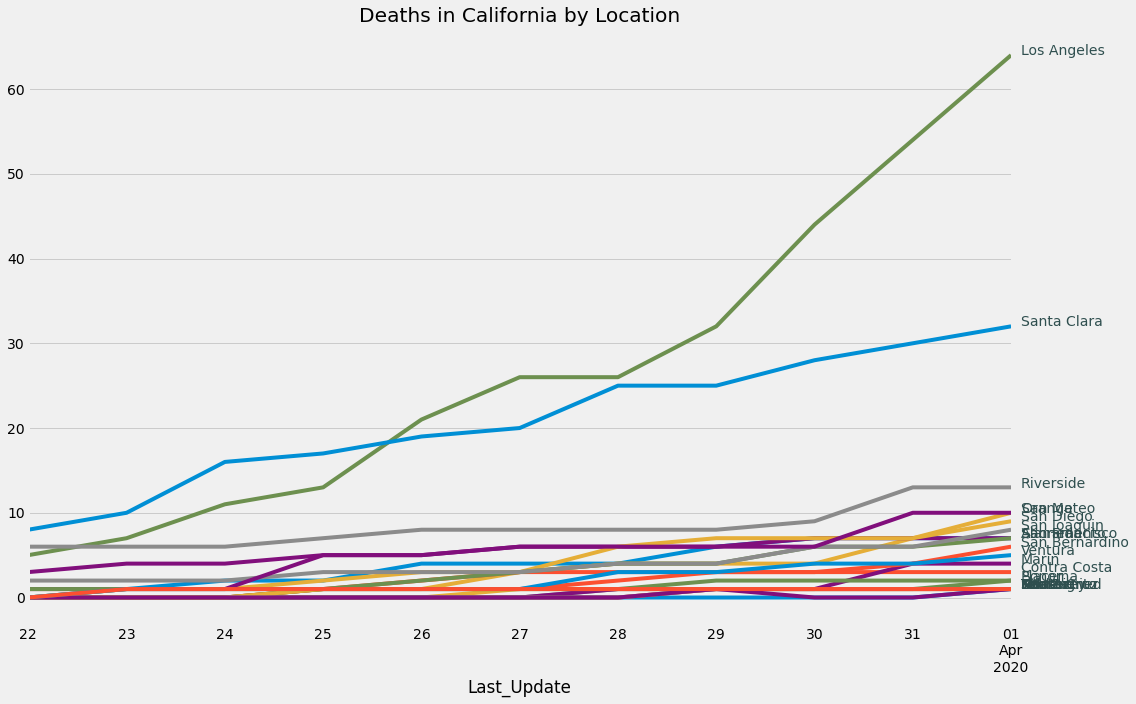

In [23]:
# graph example        
graphdf = (df.loc[:,idx[:,'Deaths',:,'California']]
           .fillna(value=0)                        # replace NaN wit zero -- filters below work better then
           .loc[:,lambda df: (df!=0).any(axis=0)]  # drop columns of all zeros
           .loc[lambda df: (df!=0).any(axis=1),:]   # drop rows of all zeros
       )
ax = graphdf.plot(legend=False)
label_lines(graphdf, ax, tuple_selector=4)
plt.title('Deaths in California by Location')
plt.tight_layout()
sns.despine()
plt.show()

In [65]:
locations = {
    'Province_State': idx[:,:,:,['California', 'Utah', 'New York', 'Hawaii', 'Idaho'],:],
    'Country_Region': idx[:,:,['Italy', 'US', 'Spain'],:,:],
    'Admin2':         idx[:,:,:,:,['Santa Clara', 'Los Angeles']]
}
last_table = None

for level, indexer in locations.items():
    test = (df.loc[:,indexer]
           .groupby(['Metric',level], axis='columns')
           .sum()
       )
    test.rename_axis(('Metric', 'Location'), axis="columns", inplace=True)
    print(test.info())
    if last_table is None:
        last_table = test
        continue
    last_table = pd.concat([last_table, test], axis=1)
df_select = last_table
df_select

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11 entries, 2020-03-22 to 2020-04-01
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   (Confirmed, California)  11 non-null     float64
 1   (Confirmed, Hawaii)      11 non-null     float64
 2   (Confirmed, Idaho)       11 non-null     float64
 3   (Confirmed, New York)    11 non-null     float64
 4   (Confirmed, Utah)        11 non-null     float64
 5   (Deaths, California)     11 non-null     float64
 6   (Deaths, Hawaii)         11 non-null     float64
 7   (Deaths, Idaho)          11 non-null     float64
 8   (Deaths, New York)       11 non-null     float64
 9   (Deaths, Utah)           11 non-null     float64
dtypes: float64(10)
memory usage: 968.0 bytes
None
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11 entries, 2020-03-22 to 2020-04-01
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  -

Metric       Confirmed                                   Deaths               \
Location    California Hawaii  Idaho New York   Utah California Hawaii Idaho   
Last_Update                                                                    
2020-03-22      1646.0   53.0   42.0  15800.0  162.0       30.0    0.0   0.0   
2020-03-23      2108.0   56.0   68.0  20884.0  257.0       39.0    0.0   0.0   
2020-03-24      2538.0   90.0   81.0  25681.0  298.0       50.0    1.0   0.0   
2020-03-25      2998.0   91.0   91.0  30841.0  340.0       65.0    0.0   0.0   
2020-03-26      3899.0   95.0  146.0  37877.0  396.0       81.0    0.0   3.0   
2020-03-27      4657.0  106.0  205.0  44876.0  472.0       94.0    0.0   3.0   
2020-03-28      5095.0  149.0  234.0  52410.0  602.0      110.0    0.0   4.0   
2020-03-29      5852.0  149.0  281.0  59648.0  720.0      124.0    0.0   5.0   
2020-03-30      7138.0  175.0  340.0  66663.0  804.0      146.0    0.0   6.0   
2020-03-31      8210.0  204.0  515.0  75833.0  888.0      173.0    0.0   8.0   
2020-04-01      9399.0  224.0  566.0  83948.0  888.0      199.0    1.0   9.0   

Metric                     ...                          Recovered           \
Location    New York Utah  ...    Italy   Spain      US     Italy    Spain   
Last_Update                ...                                               
2020-03-22     117.0  1.0  ...   5476.0  1756.0   427.0    7024.0   2125.0   
2020-03-23     158.0  1.0  ...   6077.0  2311.0   552.0    7432.0   3355.0   
2020-03-24     210.0  1.0  ...   6820.0  2808.0   706.0    8326.0   3794.0   
2020-03-25     285.0  1.0  ...   7503.0  3647.0   942.0    9362.0   5367.0   
2020-03-26     385.0  1.0  ...   8215.0  4365.0  1209.0   10361.0   7015.0   
2020-03-27     527.0  1.0  ...   9134.0  5138.0  1581.0   10950.0   9357.0   
2020-03-28     728.0  1.0  ...  10023.0  5982.0  2026.0   12384.0  12285.0   
2020-03-29     965.0  2.0  ...  10779.0  6803.0  2467.0   13030.0  14709.0   
2020-03-30    1218.0  4.0  ...  11591.0  7716.0  2978.0   14620.0  16780.0   
2020-03-31    1550.0  5.0  ...  12428.0  8464.0  3873.0   15729.0  19259.0   
2020-04-01    1941.0  5.0  ...  13155.0  9387.0  4757.0   16847.0  22647.0   

Metric                Confirmed                  Deaths              
Location         US Los Angeles Santa Clara Los Angeles Santa Clara  
Last_Update                                                          
2020-03-22      0.0       407.0       263.0         5.0         8.0  
2020-03-23      0.0       536.0       302.0         7.0        10.0  
2020-03-24    348.0       662.0       375.0        11.0        16.0  
2020-03-25    361.0       812.0       459.0        13.0        17.0  
2020-03-26    681.0      1229.0       542.0        21.0        19.0  
2020-03-27    869.0      1465.0       574.0        26.0        20.0  
2020-03-28   1072.0      1465.0       591.0        26.0        25.0  
2020-03-29   2665.0      1829.0       646.0        32.0        25.0  
2020-03-30   5644.0      2474.0       848.0        44.0        28.0  
2020-03-31   7024.0      3019.0       890.0        54.0        30.0  
2020-04-01   8474.0      3518.0       956.0        64.0        32.0  

[11 rows x 25 columns]

In [71]:
df_select['Confirmed']

Location,California,Hawaii,Idaho,New York,Utah,Italy,Spain,US,Los Angeles,Santa Clara
Last_Update,,,,,,,,,,
2020-03-22,1646.0,53.0,42.0,15800.0,162.0,59138.0,28603.0,33746.0,407.0,263.0
2020-03-23,2108.0,56.0,68.0,20884.0,257.0,63927.0,35136.0,43667.0,536.0,302.0
2020-03-24,2538.0,90.0,81.0,25681.0,298.0,69176.0,39885.0,53740.0,662.0,375.0
2020-03-25,2998.0,91.0,91.0,30841.0,340.0,74386.0,49515.0,65778.0,812.0,459.0
2020-03-26,3899.0,95.0,146.0,37877.0,396.0,80589.0,57786.0,83836.0,1229.0,542.0
2020-03-27,4657.0,106.0,205.0,44876.0,472.0,86498.0,65719.0,101657.0,1465.0,574.0
2020-03-28,5095.0,149.0,234.0,52410.0,602.0,92472.0,73235.0,121478.0,1465.0,591.0
2020-03-29,5852.0,149.0,281.0,59648.0,720.0,97689.0,80110.0,140886.0,1829.0,646.0
2020-03-30,7138.0,175.0,340.0,66663.0,804.0,101739.0,87956.0,161807.0,2474.0,848.0


In [67]:
test = (df.loc[:,idx[Any,'Confirmed',Any,states,Any]]
           .groupby('Province_State', axis='columns')
           .sum()
       )
test

Province_State,California,Hawaii,Idaho,New York,Utah
Last_Update,,,,,
2020-03-22,1646.0,53.0,42.0,15800.0,162.0
2020-03-23,2108.0,56.0,68.0,20884.0,257.0
2020-03-24,2538.0,90.0,81.0,25681.0,298.0
2020-03-25,2998.0,91.0,91.0,30841.0,340.0
2020-03-26,3899.0,95.0,146.0,37877.0,396.0
2020-03-27,4657.0,106.0,205.0,44876.0,472.0
2020-03-28,5095.0,149.0,234.0,52410.0,602.0
2020-03-29,5852.0,149.0,281.0,59648.0,720.0
2020-03-30,7138.0,175.0,340.0,66663.0,804.0


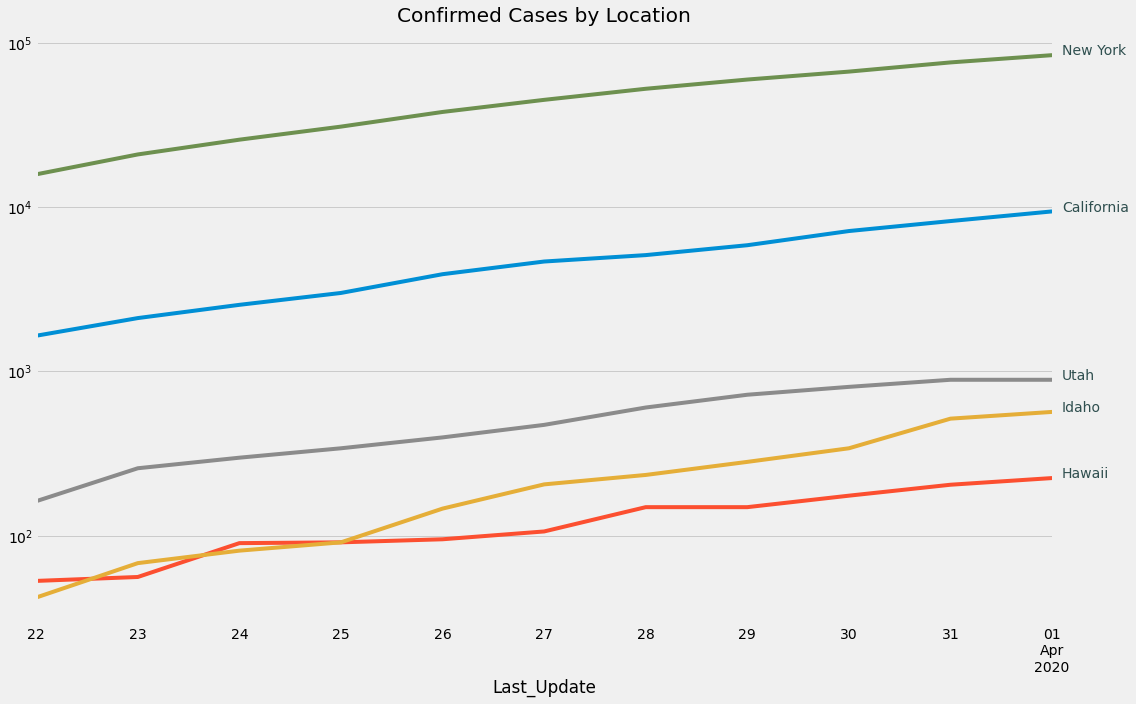

In [35]:
graphdf = df.loc[:,idx[Any,'Confirmed',Any,['California', 'Utah', 'New York', 'Hawaii', 'Idaho'],Any]].groupby('Province_State', axis='columns').sum()
ax = graphdf.plot(logy=True, legend=False)
label_lines(graphdf, ax, tuple_selector=None)
plt.title('Confirmed Cases by Location')
plt.tight_layout()
sns.despine()
plt.show()
